## 1. Pycaret
- best 4 models stacking ensemble (et, rf, xgb_tune, lgbm_tune)

In [1]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 135.1 MB/s eta 

In [1]:
import os
import numpy as np
import pandas as pd

# 데이터 읽어오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split

X = train.drop('critical_temp', axis=1)
y = train['critical_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=train['number_of_elements'], random_state=123)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

reg = setup(data=train_data, test_data=test_data, target='critical_temp', ignore_features=['ID'], use_gpu=True, session_id=123)

,Description,Value
0,Session id,123
1,Target,critical_temp
2,Target type,Regression
3,Original data shape,"(12759, 83)"
4,Transformed data shape,"(12759, 82)"
5,Transformed train set shape,"(10207, 82)"
6,Transformed test set shape,"(2552, 82)"
7,Ignore features,1
8,Numeric features,81
9,Preprocess,True


In [ ]:
best = compare_models(n_select=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:39:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,7.2015,158.0512,12.5492,0.8649,0.4786,7.8309,0.0960
dt,Decision Tree Regressor,7.2752,187.7153,13.6833,0.8393,0.5027,5.7561,0.8350
lr,Linear Regression,13.7320,322.8436,17.9584,0.7238,0.8630,21.6876,0.1500
br,Bayesian Ridge,13.7782,324.3459,17.9995,0.7225,0.8615,22.8297,0.4230
ridge,Ridge Regression,14.0530,332.8137,18.2328,0.7153,0.8630,23.3316,0.0950
huber,Huber Regressor,14.4364,359.6504,18.9522,0.6924,0.8819,21.3592,0.8050
omp,Orthogonal Matching Pursuit,18.0068,525.6353,22.9141,0.5506,0.9826,29.1690,0.1050
lasso,Lasso Regression,18.3471,536.1997,23.1431,0.5416,0.9975,28.9167,0.1430
llar,Lasso Least Angle Regression,18.3467,536.1914,23.1429,0.5416,0.9975,28.9150,0.1050
en,Elastic Net,18.6457,552.7002,23.4961,0.5275,1.0018,25.4868,0.1440


Processing:   0%|          | 0/88 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5.6583,105.5268,10.2388,0.9098,0.4016,5.5750,3.0270
rf,Random Forest Regressor,6.0041,110.2275,10.4775,0.9058,0.4244,6.1011,9.8890
xgboost,Extreme Gradient Boosting,6.2669,114.3243,10.6608,0.9023,0.4535,6.6387,0.7420
lightgbm,Light Gradient Boosting Machine,6.7470,117.3874,10.8145,0.8997,0.4947,8.3199,0.6990
catboost,CatBoost Regressor,7.1228,126.9703,11.2489,0.8915,0.5012,8.8208,9.8010
knn,K Neighbors Regressor,7.2015,158.0512,12.5492,0.8649,0.4786,7.8309,0.0960
gbr,Gradient Boosting Regressor,8.8170,167.6952,12.9390,0.8566,0.6007,8.9266,18.5280
dt,Decision Tree Regressor,7.2752,187.7153,13.6833,0.8393,0.5027,5.7561,0.8350
lr,Linear Regression,13.7320,322.8436,17.9584,0.7238,0.8630,21.6876,0.1500
br,Bayesian Ridge,13.7782,324.3459,17.9995,0.7225,0.8615,22.8297,0.4230


In [ ]:
best[2] = tune_model(best[2], optimize='MAE', n_iter=100)
best[3] = tune_model(best[3], optimize='MAE', n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3068,127.4961,11.2914,0.8918,0.4430,0.9960
1,5.6607,98.7271,9.9362,0.9140,0.3979,1.7328
2,6.0345,105.1191,10.2528,0.9074,0.4026,0.7471
3,5.6319,91.1088,9.5451,0.9252,0.3860,10.5948
4,5.7023,125.9065,11.2208,0.8978,0.3957,28.3449
5,6.3604,135.5881,11.6442,0.8866,0.4532,12.7197
6,5.5453,98.7470,9.9372,0.9119,0.4045,0.9650
7,5.7030,99.7494,9.9875,0.9131,0.4135,1.5561
8,5.6789,92.6807,9.6271,0.9236,0.3833,3.3974


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3059,122.0970,11.0497,0.8964,0.4528,1.1008
1,5.6760,98.5072,9.9251,0.9142,0.4086,2.2837
2,5.9813,105.4446,10.2686,0.9071,0.4057,0.7450
3,5.7800,95.8221,9.7889,0.9213,0.4083,10.4400
4,5.8145,126.2897,11.2379,0.8975,0.4063,30.4796
5,6.3725,134.0204,11.5767,0.8879,0.4728,14.2877
6,5.5661,95.7178,9.7835,0.9146,0.4254,1.0636
7,5.7181,97.6949,9.8841,0.9149,0.4233,1.5212
8,5.6633,90.7486,9.5262,0.9252,0.3959,4.1930


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
stack_finalized = finalize_model(stack_lr)

In [ ]:
df_test = pd.read_csv('test.csv')
df_test = df_test.drop(['ID'], axis=1)

df_submit = pd.read_csv('sample_submission.csv')
df_submit['critical_temp'] = stack_finalized.predict(df_test)
df_submit

,ID,critical_temp
0,TEST_00000,1.645000
1,TEST_00001,4.298290
2,TEST_00002,12.326145
3,TEST_00003,45.866133
4,TEST_00004,3.495627
...,...,...
8499,TEST_08499,8.445000
8500,TEST_08500,24.700000
8501,TEST_08501,11.678000
8502,TEST_08502,19.085715


In [ ]:
df_submit.to_csv("pycaret.csv",index=False)

## 2. autogluon
- eval_metrics = mae
- time_limits = 5400 (1h 30m)
- Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20

평가기준 별 실제 제출시 public 점수

    rmse : 0.1540
    mae :  0.1515
    r2  : 0.1529

따라서 이후 다른 학습진행시에도 mae만 사용, 앙상블에도 mae만 사용

In [ ]:
pip install autogluon

In [ ]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# 데이터 로드
train_data = TabularDataset('train.csv')
test_data = TabularDataset('test.csv')

# 모델의 평가 지표 및 시간 설정
eval_metrics = ['root_mean_squared_error', 'mean_absolute_error', 'r2']
time_limits = [5400, 5400, 5400]
model_paths = ['AutogluonModels/model_rmse_1h30m', 'AutogluonModels/model_mae_1h30m', 'AutogluonModels/model_r2_1h30m']

all_predictions = []

# 각 평가 지표로 모델 훈련 및 예측
for i, (eval_metric, time_limit, save_path) in enumerate(zip(eval_metrics, time_limits, model_paths)):
    predictor = TabularPredictor(
        label='critical_temp',
        path=save_path,
        eval_metric=eval_metric
    ).fit(
        train_data=train_data,
        presets='best_quality',
        time_limit=time_limit
    )

    test_pred = predictor.predict(test_data)
    all_predictions.append(test_pred)

    # submission 파일 저장
    submission = pd.read_csv('sample_submission.csv')
    submission['critical_temp'] = test_pred
    submission.to_csv(f'./autogluon_model_{eval_metric}_1h30m_submit.csv', index=False)

# 모든 모델의 예측값을 앙상블
ensemble_test_pred = sum(all_predictions) / len(all_predictions)

# 앙상블 결과로 submission 파일 저장
final_submission = pd.read_csv('sample_submission.csv')
final_submission['critical_temp'] = ensemble_test_pred
final_submission.to_csv('./autogluon_ensemble_1h30m_submit.csv', index=False)


Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 5400s
AutoGluon will save models to "AutogluonModels/model_rmse_1h30m/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   49.51 GB / 179.07 GB (27.6%)
Train Data Rows:    12759
Train Data Columns: 82
Label Column: critical_temp
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (185.0, 0.00032, 34.40876, 34.24424)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators t

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-8e552e138771>", line 17, in <cell line: 16>
    predictor = TabularPredictor(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/decorators.py", line 31, in _call
    return f(*gargs, **gkwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/predictor/predictor.py", line 986, in fit
    self._learner.fit(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/learner/abstract_learner.py", line 159, in fit
    return self._fit(X=X, X_val=X_val, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/learner/default_learner.py", line 157, in _fit
    trainer.fit(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/trainer/auto_trainer.py", line 114, in fit
    self._train_multi_and_ensemble

## 3. Autogluon - Feature eng with ChatGPT

ChatGPT에게 description 정보를 제공하여 도메인 지식을 바탕으로 특성 생성 요청
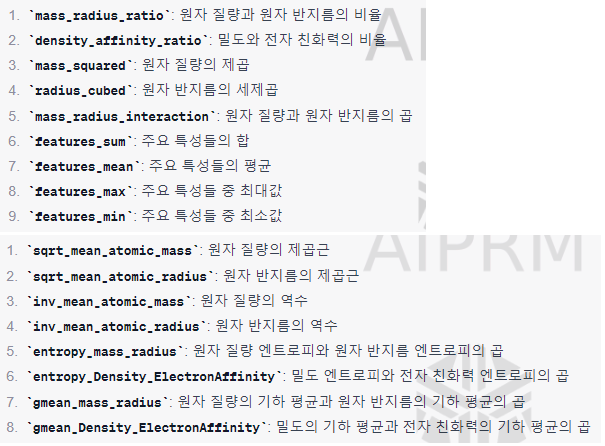

도메인지식이 없어 사실 확인은 불가하였으나, 최종적으로 성능 개선에 도움이 됨

위의 autogluon코드와 거의 일치함.

num_stack_levels = 1인경우, 2인경우로 5시간 학습한 결과들 생성

In [ ]:
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor

train_data = TabularDataset('train.csv')
test_data = TabularDataset('test.csv')

In [ ]:
# 특성 공학 함수 정의
def feature_engineering(data):
    # 비례 특성 생성
    data['mass_radius_ratio'] = data['mean_atomic_mass'] / data['mean_atomic_radius']
    data['density_affinity_ratio'] = data['mean_Density'] / data['mean_ElectronAffinity']

    # 다항 특성 생성
    data['mass_squared'] = data['mean_atomic_mass'] ** 2
    data['radius_cubed'] = data['mean_atomic_radius'] ** 3

    # 상호작용 특성 생성
    data['mass_radius_interaction'] = data['mean_atomic_mass'] * data['mean_atomic_radius']

    # 통계 특성 생성
    features = ['mean_atomic_mass', 'mean_atomic_radius', 'mean_Density', 'mean_ElectronAffinity']
    data['features_sum'] = data[features].sum(axis=1)
    data['features_mean'] = data[features].mean(axis=1)
    data['features_max'] = data[features].max(axis=1)
    data['features_min'] = data[features].min(axis=1)

    # 추가 특성 생성
    data['sqrt_mean_atomic_mass'] = np.sqrt(data['mean_atomic_mass'])
    data['sqrt_mean_atomic_radius'] = np.sqrt(data['mean_atomic_radius'])
    data['inv_mean_atomic_mass'] = 1 / (data['mean_atomic_mass'] + 1e-10)
    data['inv_mean_atomic_radius'] = 1 / (data['mean_atomic_radius'] + 1e-10)
    data['entropy_mass_radius'] = data['entropy_atomic_mass'] * data['entropy_atomic_radius']
    data['entropy_Density_ElectronAffinity'] = data['entropy_Density'] * data['entropy_ElectronAffinity']
    data['gmean_mass_radius'] = data['gmean_atomic_mass'] * data['gmean_atomic_radius']
    data['gmean_Density_ElectronAffinity'] = data['gmean_Density'] * data['gmean_ElectronAffinity']

    return data

# 특성 공학 적용
train_data_fe = feature_engineering(train_data)
test_data_fe = feature_engineering(test_data)

In [ ]:
# 모델 훈련 및 예측 함수
def train_and_predict(num_stack_levels):
    eval_metric = 'mean_absolute_error'
    time_limit = 3600*5
    save_path = f'AutogluonModels/model_mae_s{num_stack_levels}_820_3h'

    predictor = TabularPredictor(
        label='critical_temp',
        path=save_path,
        eval_metric=eval_metric,
        problem_type='regression'
    ).fit(
        train_data=train_data,
        presets='best_quality',
        time_limit=time_limit,
        num_stack_levels=num_stack_levels,
        num_bag_folds=8,
        num_bag_sets=20
    )

    test_pred = predictor.predict(test_data)

    # submission 파일 생성
    submission = pd.read_csv('sample_submission.csv')
    submission['critical_temp'] = test_pred
    submission_path = f'./autogluon_model_fe_{num_stack_levels}_8_20.csv'
    submission.to_csv(submission_path, index=False)

    return submission_path

# num_stack_levels=1인 경우
submission_path_1 = train_and_predict(1)
print(submission_path_1)

# num_stack_levels=2인 경우
submission_path_2 = train_and_predict(2)
print(submission_path_2)


## 최종 결과 앙상블 코드

In [ ]:
import pandas as pd
import os

# 경로 설정
folder_path = '/ensemble'

# 해당 폴더에 있는 모든 CSV 파일 리스트 생성
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# 파일들을 하나씩 불러와서 앙상블
ensemble_df = pd.read_csv(os.path.join(folder_path, csv_files[0])).copy()
ensemble_df['critical_temp'] = 0

for csv_file in csv_files:
    current_df = pd.read_csv(os.path.join(folder_path, csv_file))
    ensemble_df['critical_temp'] += current_df['critical_temp']

# 평균 계산
ensemble_df['critical_temp'] /= len(csv_files)

# 앙상블 결과로 submission 파일 저장
ensemble_df.to_csv(os.path.join(folder_path, "py_mae130_fe5h1820_fe5h2820.csv"), index=False)